In [ ]:
!pip install scikit-learn

In [28]:
import time

#imports for file handling
import os
import scipy
from scipy.sparse import save_npz
from scipy.sparse import load_npz
import json

# imports for data processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Convert BVH to NPZ Files

BVH file is broken down into the joint hierarchy information and the local positions/rotations of the joints at each frame. For this, we only care about the local position of the joints and not the mapping of data to joint name of about converting the local coordinates to global coordinates.

"All joints are represented by local transforms
with respect to parent joints; a global pose of the pelvis is
provided with respect to a fixed frame"

In [2]:
#Don't need to rerun - used to create dsv_data
def convert_file(file_in, file_out):
    file = open(file_in, "r")
    full_data = file.readlines()
    i = full_data.index("MOTION\n")
    frames = int(full_data[i+1].strip().replace("Frames: ", ""))
    frame_time = float(full_data[i+2].strip().replace("Frame Time: ", ""))

    pos_data = [] # frame [ 83 joints [xpos, ypos, zpos, zrot, xrot, yrot]]]
    for frame in full_data[i+3: ]:
        pos_data.append( [float(x) for x in frame.split()])
    
    # take the derivative to get acceleration
    pos_data = np.array(pos_data)
    v_data = np.diff(pos_data, 1, 0)
    acc_data = np.diff(pos_data, 2, 0)
    
    # How much does taking the derivative reduce the amount of non zero data?
    total_size = np.size(pos_data)
    # print(total_size , round(np.count_nonzero(pos_data)/total_size*100,4), round(np.count_nonzero(acc_data)/total_size*100, 4))
    # ~ 70 -> 20%
    
    # cut out the first ~5 seconds on each side of the take to remove weird artifacts
    acc_data = acc_data[500: -500]
    sparse_data = scipy.sparse.csr_matrix(acc_data)
    save_npz(file_out, sparse_data)
    # TODO - is there a better way to store this that capitalizes on the sparsity?

    file.close()
    return len(acc_data), frame_time

In [3]:
# For each BVH file, clean up the file strucutre and write out the local acceleation
start_time = time.time()
data_dir = "mocap_data"

frames = []
frame_length = []

# iterate through the session directories
for session_dir in [x for x in os.listdir(data_dir) if x.startswith("session")]:
    session_path = os.path.join(data_dir, session_dir)
    for take_dir in [x for x in os.listdir(session_path) if x.startswith("take")]:
        # reformat file strucutre so all info if in file name so we don't have to recurse later
        take_path = os.path.join(session_path, take_dir)
        file_a, file_b =  [x for x in os.listdir(take_path) if ".bvh" in x]
        # Get file path for each of the bvh files
        person_a = file_a.replace(take_dir + "_hasFingers_", "").replace("_scale_local.bvh", "")
        person_b = file_b.replace(take_dir + "_hasFingers_", "").replace("_scale_local.bvh", "")
        # Convert the bvh file to a npz file with sparse acceleration data
        new_a = "npz_take_data/" + person_a + "_" + person_b + "_" + session_dir.replace("ession", "") + take_dir.replace("ake", "") + '.npz'
        f, f_len = convert_file(os.path.join(take_path, file_a), new_a)
        frames.append(f)
        frame_length.append(f_len)
        # Exact same thing but for person b           
        new_b = "npz_take_data/" + person_b + "_" + person_a + "_" + session_dir.replace("ession", "") + take_dir.replace("ake", "") + '.npz'
        f, f_len = convert_file(os.path.join(take_path, file_b), new_b)
        frames.append(f)
        frame_length.append(f_len)
        
print("Time to complete (mins): ", (time.time()-start_time)/60)

670.2732229232788


In [4]:
# Are all frames captured at the same frame rate?
if (len(set(frame_length)) == 1):
    print("All frame rates are the same: ", frame_length[0])
else:
    print("ERROR: Need to account for differnces in frame rate")
          
print("Total data (minutes): ", sum(frames)*frame_length[0]/60)
print("Shortest take: ", np.min(frames))
print("Longest take (relative to shortest): ", np.max(frames)/np.min(frames))

All frame rates are the same:  0.0111111111111
Total data (minutes):  534.4140740735397
Shortest take:  5226
Longest take (relative to shortest):  20.192307692307693


# Load in Take data to create full data matrix

In [15]:
start_time = time.time()

data = None
l = 5226 # Number of frames in the shortest take, 56 files
speakers = []
listeners = []

# format data so that each column is a
for file in [x for x in os.listdir("npz_take_data") if ".npz" in x]:
    info = file.split("_")
    d = load_npz(os.path.join("npz_take_data", file)).toarray() # convert back to numpy to handle
    for i in range(d.shape[0]//l): # use numpy reshape instead??
        chunk = np.array(d[i*l: (i+1)*l]).flatten()
        speakers.append(info[0])
        listeners.append(info[1])
        if (data is None):
            data = [chunk]
        else:
            data.append(chunk) # using numpy is slooowwww
            
print(time.time() - start_time)

Save / Load from files as needed

In [20]:
import json

In [22]:
start_time = time.time()
#Write out to file
data = np.transpose(np.array(data)) # each column is a series of accelerations from within a take
print(data.shape)
sparse_data =  scipy.sparse.csr_matrix(data)
print("is this the slow part?  ", (time.time() - start_time)/60)
save_npz('sparse_data.npz', sparse_data)

with open('pair_ids.json', 'w') as f:
    json.dump({"speakers": speakers, "listners": listeners}, f)
     
print((time.time() - start_time)/60) # should run in ~ 

(526, 2602548)
is this the slow part?   135.57144498825073
346.74361181259155


In [26]:
start_time = time.time()
# Reload if needed
data = load_npz('sparse_data.npz').toarray()

with open('pair_ids.json', 'r') as f:
    x = json.load(f)
    speakers = x['speakers']
    listeners = x['listners']
    
print((time.time() - start_time)/60) # should run in ~

0.48317848443984984


### Speaker vs. Data Distribution

What is the actual breakdown of number of chunks for each speaker pair? For each speaker?

Total chunks:  526
Total data length (hrs):  8.483336766666666


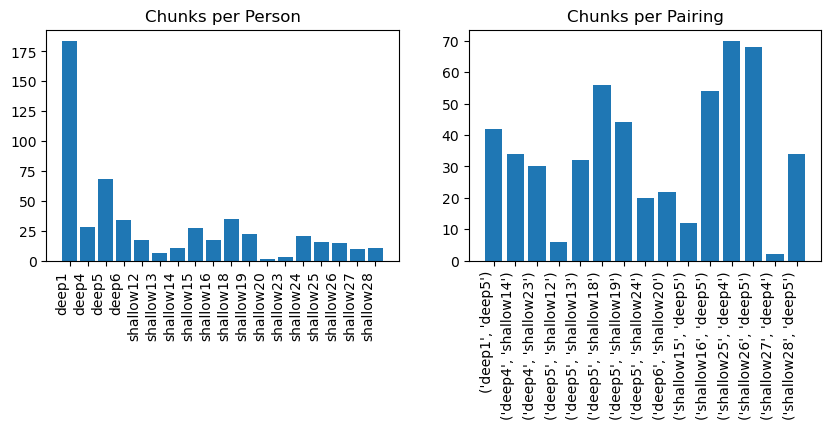

In [44]:
# create a dictionary of counts for each (speaker, listener) pair
print("Total chunks: ", len(speakers))
print("Total data length (hrs): ", ((len(speakers)*5226*0.01111)/60)/60) #frames per chunk, and frames per second
pairs = {}
speaker_freq = {}
for i, speaker in enumerate(speakers):
    listener = listeners[i]
    # Track how many chunks for each person
    if speaker in speaker_freq:
        speaker_freq[speaker] += 1
    else:
        speaker_freq[speaker] =1
    # Track how many chunks for each pair of people
    if (speaker, listener) in pairs:
        pairs[(speaker, listener)] += 1
    elif (listener, speaker) in pairs:
        pairs[(listener, speaker)] += 1
    else:
        pairs[(speaker, listener)] = 1

# get the unique pairs of speakers and listeners
unique_pairs = sorted(set(pairs.keys()))
unique_people = sorted(set(speaker_freq.keys()))

# create a list of counts for each unique pair of speakers and listeners
pairs_list = [pairs[pair] for pair in unique_pairs]
people_count = [speaker_freq[x] for x in speaker_freq]

# set up the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# create the left bar chart
axs[0].bar(np.arange(len(unique_people)), people_count)
axs[0].set_xticks(np.arange(len(unique_people)))
axs[0].set_xticklabels(unique_people, rotation=90, ha="right")
axs[0].set_title("Chunks per Person")

# create the right bar chart
axs[1].bar(np.arange(len(unique_pairs)), pairs_list)
axs[1].set_xticks(np.arange(len(unique_pairs)))
axs[1].set_xticklabels(unique_pairs, rotation=90, ha="right")
axs[1].set_title("Chunks per Pairing")

plt.show()

## Is there any other preprocessing that we need to do - normalization or otherwise?

## TODO, SVD -> PCA, Or direct PCA to reduce dimensionality

In [47]:
# Should take ~13 seconds
start_time = time.time()
sparse_data = load_npz('sparse_data.npz').toarray()
print(time.time()-start_time)
print(sparse_data.shape)

21.741039991378784
(526, 2602548)


In [49]:
# reduce down to subset of features - Takes 10 minutes if the wrong way, 2-4min the correct way
start_time = time.time()
pca = PCA(n_components=3)
pca_feats = pca.fit_transform(data)
print((time.time()-start_time)/60)
print(pca_feats.shape)

284.53255701065063


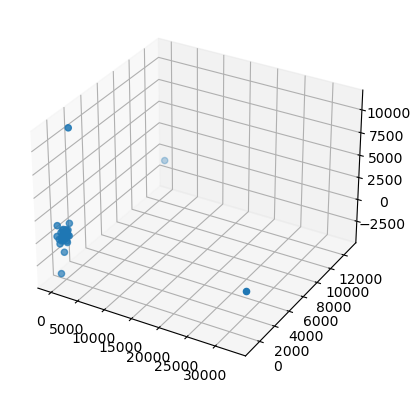

In [54]:
# TODO: Add color coding

# create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot the points
ax.scatter(pca_feats[:,0], pca_feats[:,1], pca_feats[:,2])
# show the plot
plt.show()

(526,)


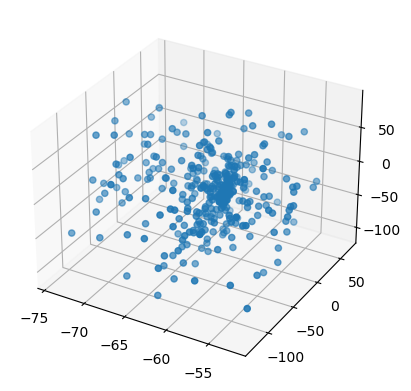

In [55]:
# create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# find the quartiles for each dimension
pca_feats_sorted = np.sort(pca_feats, axis=0)
n = pca_feats_sorted.shape[0]
q1 = pca_feats_sorted[n // 4]
q3 = pca_feats_sorted[n // 4 * 3]

# compute the interquartile range for each dimension
iqr = q3 - q1

# define the lower and upper bounds for outliers
lb = q1 - 1.5 * iqr
ub = q3 + 1.5 * iqr

# identify the outliers
outliers = np.logical_or(pca_feats < lb, pca_feats > ub)
outliers = np.any(outliers, axis=1) 
print(outliers.shape)

# plot the non-outliers
x = pca_feats[:, 0][~outliers]
y = pca_feats[:, 1][~outliers]
z = pca_feats[:, 2][~outliers]
ax.scatter(x, y, z)

# show the plot
plt.show()
